**OBJETIVO:**Utilizar los datos de la competición de predicción de los datos del Dengue. Para nuestro primer modelo, utilizaremos como base la regresion lineal. Tambien se utilizaran las variables identificadas en la actividad 1 que seran las que potencialmente proporcionarian informacion relevante para hacer las predicciones. Mas información en enlace

**Tecnica usada : [DT](https://scikit-learn.org/stable/modules/tree.html)**
un método de aprendizaje supervisado no paramétrico utilizado para la clasificación y la regresión. El objetivo es crear un modelo que prediga el valor de una variable de destino mediante el aprendizaje de reglas de decisión simples deducidas de las características de datos.

ACTUALIZACION DE LIBRERIAS Debido que se realizan diferentes graficos y se invocan las funciones np, sns, files como otros, es necesario bajar cuantas librerias sea necesario para eviar errores la momento de compilacion.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Subir el dataset train features
features = pd.read_csv('/content/drive/My Drive/dengue_features_train.csv') 

#Subir el dataset Labels (o etiquetas)
labels =pd.read_csv('/content/drive/My Drive/dengue_labels_train.csv') 

#Subir el dataset training
test = pd.read_csv('/content/drive/My Drive/dengue_features_test.csv')

#fill NaNs - Eliminacion de Nulls
test.fillna(method='ffill', inplace=True)

#Eliminacion de Columna innecesaria para test y training (tenemos que alinear para que el array tenga la misma dimension)
features.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)

Usar el link alternativo de abajo si no tienes los archivos en google drive.

In [ ]:
#features = pd.read_csv('dengue_features_train.csv')
#labels = pd.read_csv('dengue_labels_train.csv')
#test = pd.read_csv('dengue_features_test.csv')

**Transformacion de datos:** La transformacion d elos datos estan basadas en la actividad 1. 
Se comienza con la normalizacion de las temperaturas de K a C.

In [ ]:
temperature_kelvin_columns = [i for i in features.columns if i.find('_temp_k') > -1]
temperature_kelvin_columns

['reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k']

In [ ]:
for i in temperature_kelvin_columns:
    features[i] =features[i] - 273.15

In [ ]:
for i in temperature_kelvin_columns:
   test[i] =test[i] - 273.15

In [ ]:
#Renombramos el heading de las columnas de K a C
features.columns = [i.replace('_temp_k', '_temp_c') 
                           for i in features.columns if i.find('_temp_k')]

In [ ]:
#Renombramos el heading de las columnas de K a C
test.columns = [i.replace('_temp_k', '_temp_c') 
                           for i in test.columns if i.find('_temp_k')]

En base a la actividad uno y de acuerdo al analisis de correlacion se calculara la mediana de los estaciones para intentar obtener una mejor prediccion.
La nueva columna sera llamada 'avg_station_max_min'.

In [ ]:
features['avg_station_max_min'] = (features['station_max_temp_c'] + 
                                          features['station_min_temp_c']) / 2

features['avg_station_max_min'].head()

0    24.70
1    26.95
2    27.50
3    28.30
4    29.45
Name: avg_station_max_min, dtype: float64

Realizamos el mismo paso para test:

In [ ]:
test['avg_station_max_min'] = (test['station_max_temp_c'] + 
                                          test['station_min_temp_c']) / 2

test['avg_station_max_min'].head()

0    27.50
1    26.10
2    27.80
3    28.85
4    28.30
Name: avg_station_max_min, dtype: float64

In [ ]:
features['avg_reanalysis_max_min'] = (features['reanalysis_max_air_temp_c'] + 
                                           features['reanalysis_min_air_temp_c']) / 2

features['avg_reanalysis_max_min'].head()

0    24.70
1    25.50
2    25.75
3    26.05
4    26.55
Name: avg_reanalysis_max_min, dtype: float64

Se aplica un promediado similar para las variables reanalysis_max_air_temp_c' y 'reanalysis_max_air_temp_c'

In [ ]:
test['avg_reanalysis_max_min'] = (test['reanalysis_max_air_temp_c'] + 
                                           test['reanalysis_min_air_temp_c']) / 2

test['avg_reanalysis_max_min'].head()

0    25.60
1    25.60
2    26.15
3    26.80
4    26.65
Name: avg_reanalysis_max_min, dtype: float64

In [ ]:
features.head(1)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,avg_station_max_min,avg_reanalysis_max_min
0,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,24.422857,24.592857,19.264286,26.65,22.75,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,24.7,24.7


Dividimos los dataframe para separlos de las ciudades pertinentes **'SJ' y 'IQ'**

In [ ]:
X_train_sj = features.loc[features.city=='sj'].copy()
y_train_sj = labels.loc[labels.city=='sj'].copy()

X_train_iq = features.loc[features.city=='iq'].copy()
y_train_iq = labels.loc[labels.city=='iq'].copy()

test_sj_ = test.loc[test.city=='sj'].copy()
test_iq_ = test.loc[test.city=='iq'].copy()
X_test_sj=  test_sj_.copy()
X_test_iq = test_iq_.copy()


print('features: ', X_train_sj.shape)
print('labels  : ', y_train_sj.shape)

print('\nIquitos')
print('features: ',X_train_iq.shape)
print('labels  : ', y_train_iq.shape)

features:  (936, 25)
labels  :  (936, 4)

Iquitos
features:  (520, 25)
labels  :  (520, 4)


In [ ]:
X_train_sj['total_cases'] = y_train_sj['total_cases']
X_train_iq['total_cases'] = y_train_iq['total_cases']


Se asegura que no existan NaNs en las variables. Y se convierten correspondinte mente.

In [ ]:
X_train_sj.fillna(method='bfill', inplace=True)
X_train_iq.fillna(method='bfill', inplace=True)
X_test_sj.fillna(method='bfill', inplace=True)
X_test_iq.fillna(method='bfill', inplace=True)

In [ ]:
features = ['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']

In [ ]:
X_train_sj = X_train_sj[features].copy()
X_train_iq = X_train_iq[features].copy()
X_test_sj = X_test_sj[features[1:]].copy()
X_test_iq = X_test_iq[features[1:]].copy()

Verificamos la correlacion entre las variables seleccionadas con respecto al numero de casos.

Text(0.5, 1.0, 'Correlations for San Juan')

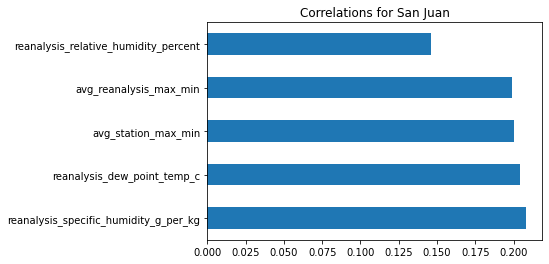

In [ ]:
sj_correlations = X_train_sj.corr()
iq_correlations = X_train_iq.corr()
(sj_correlations['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh())
plt.title('Correlations for San Juan')

El siguiente Plot nos da mas infomracion de acuerdo al ano y semenas que se presentan mas casos. Con esta informacion podriamos descartar algunos timeseries or anos en donde las predicciones no aportan mucha infomacion.

Text(0, 0.5, 'Number of Cases')

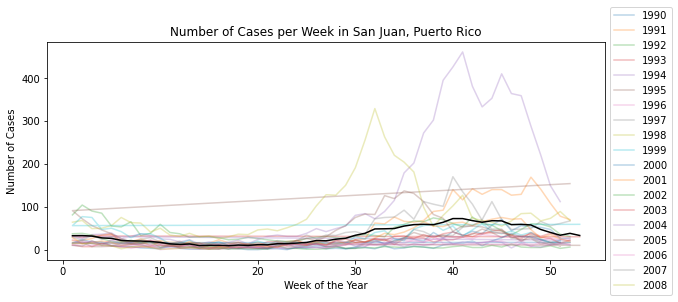

In [ ]:
for i in set(y_train_sj['year']):
    df = y_train_sj[y_train_sj['year'] == i]
    df.set_index('weekofyear', drop = True, inplace = True)
    plt.plot(df['total_cases'], alpha = .3)
    
y_train_sj.groupby('weekofyear')['total_cases'].mean().plot(c = 'k', figsize = (10,4))
plt.legend(set(y_train_sj['year']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Number of Cases per Week in San Juan, Puerto Rico')
plt.xlabel('Week of the Year')
plt.ylabel('Number of Cases')

Se ejecuta el split (division de los datos para training y test). Se deja por defecto el tamano de test de 0.33

MODELO SOBRE EL CONJUNTO DE TRAINING

In [ ]:
#1.1 Model Parametrization  
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
#splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeRegressor
regressorsj = DecisionTreeRegressor(criterion='mae', max_depth=10, random_state=0)

[Text(167.4, 181.2, 'X[0] <= 16.145\nmse = 2637.225\nsamples = 936\nvalue = 34.181'),
 Text(83.7, 108.72, 'X[2] <= 81.286\nmse = 404.507\nsamples = 362\nvalue = 20.199'),
 Text(41.85, 36.23999999999998, 'mse = 360.081\nsamples = 345\nvalue = 19.194'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 869.889\nsamples = 17\nvalue = 40.588'),
 Text(251.10000000000002, 108.72, 'X[0] <= 19.001\nmse = 3844.277\nsamples = 574\nvalue = 42.998'),
 Text(209.25, 36.23999999999998, 'mse = 3698.137\nsamples = 566\nvalue = 41.924'),
 Text(292.95, 36.23999999999998, 'mse = 8325.75\nsamples = 8\nvalue = 119.0')]

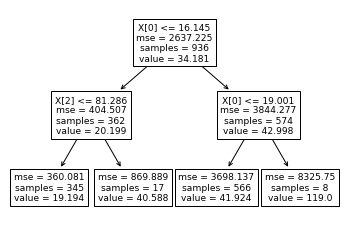

In [ ]:
from sklearn import tree
tree.plot_tree(regressorsj)

In [ ]:
#1.1.1 Model construction IQ
regressorsj.fit(X_train_sj[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_sj['total_cases'])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
#1..1.2 Model construction SJ
regressorsj.fit(X_train_sj[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_sj['total_cases'])

print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressorsj.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,total_cases,0.992693
1,reanalysis_specific_humidity_g_per_kg,0.000778
2,reanalysis_dew_point_temp_c,0.001729
3,reanalysis_relative_humidity_percent,0.003459
4,avg_station_max_min,0.000130
5,avg_reanalysis_max_min,0.001211


In [ ]:
#1.1.2 Model Parametrization 
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
#splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeRegressor
regressoriq = DecisionTreeRegressor(criterion='mae', max_depth=10, random_state=0)

[Text(167.4, 181.2, 'X[0] <= 17.708\nmse = 115.673\nsamples = 520\nvalue = 7.565'),
 Text(83.7, 108.72, 'X[3] <= 27.675\nmse = 68.299\nsamples = 305\nvalue = 5.249'),
 Text(41.85, 36.23999999999998, 'mse = 37.828\nsamples = 188\nvalue = 3.867'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 109.258\nsamples = 117\nvalue = 7.47'),
 Text(251.10000000000002, 108.72, 'X[4] <= 28.325\nmse = 164.471\nsamples = 215\nvalue = 10.851'),
 Text(209.25, 36.23999999999998, 'mse = 190.87\nsamples = 176\nvalue = 11.699'),
 Text(292.95, 36.23999999999998, 'mse = 27.461\nsamples = 39\nvalue = 7.026')]

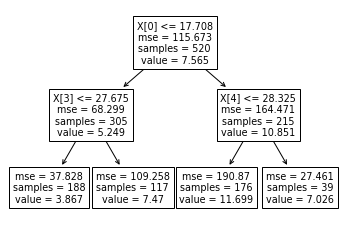

In [ ]:
from sklearn import tree
tree.plot_tree(regressoriq)

In [ ]:
#1.1.3 Model construction IQ
regressoriq.fit(X_train_iq[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_iq['total_cases'])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
#1.2 Model construction IQ
regressoriq.fit(X_train_iq[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_iq['total_cases'])

print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressoriq.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,total_cases,0.977432
1,reanalysis_specific_humidity_g_per_kg,0.002543
2,reanalysis_dew_point_temp_c,0.001589
3,reanalysis_relative_humidity_percent,0.000318
4,avg_station_max_min,0.017800
5,avg_reanalysis_max_min,0.000318


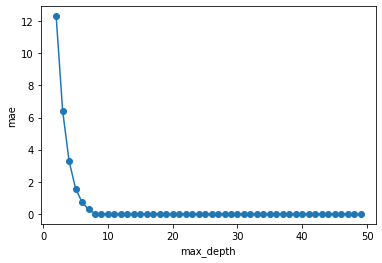

In [ ]:
# Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 50):
    regressorsj = DecisionTreeRegressor(max_depth=i)
    regressorsj.fit(X_train_sj[['total_cases','reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_sj['total_cases'])
    pred_values = regressorsj.predict(X_train_sj[['total_cases','reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']])
    maev = mean_absolute_error(X_train_sj['total_cases'],pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Text(0, 0.5, 'mae')

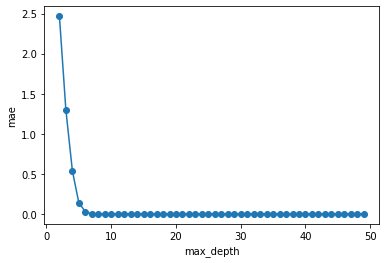

In [ ]:
#Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 50):
    regressoriq = DecisionTreeRegressor(max_depth=i)
    regressoriq.fit(X_train_iq[['total_cases','reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']], X_train_iq['total_cases'])
    pred_values = regressoriq.predict(X_train_iq[['total_cases','reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_c', 'reanalysis_relative_humidity_percent', 'avg_station_max_min', 'avg_reanalysis_max_min']])
    maev = mean_absolute_error(X_train_iq['total_cases'],pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Min Value 30.12095554795811 (2)


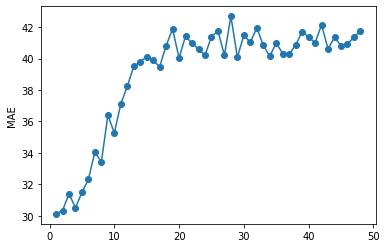

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = False, random_state=0) # 

# reset index
X_train_sj.reset_index(drop = True, inplace = True)
X_train_sj.head()

total_scores = []
for i in range(2, 50):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(X_train_sj):
      # División train test aleatoria
      f_train = X_train_sj.loc[train_fold]
      f_test = X_train_sj.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Min Value 6.76314604056073 (2)


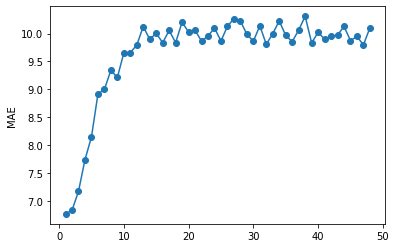

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = False, random_state=0) # 

# reset index
X_train_iq.reset_index(drop = True, inplace = True)
X_train_iq.head()

total_scores = []
for i in range(2, 50):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(X_train_iq):
      # División train test aleatoria
      f_train = X_train_iq.loc[train_fold]
      f_test = X_train_iq.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 


In [ ]:
# constructor
regressorsj = DecisionTreeRegressor(max_depth = max_depth)
# fit and predict
X = X_train_sj.drop(['total_cases'], axis=1)
y = y_train_sj['total_cases']

regressorsj.fit( X, y)
y_pred = regressorsj.predict(X)
mae = mean_absolute_error(y, y_pred)
print ('MAE', mae)


MAE 26.893539117550894


In [ ]:
# constructor
regressoriq = DecisionTreeRegressor(max_depth = max_depth)
# fit and predict
X = X_train_iq.drop(['total_cases'], axis=1)
y = y_train_iq['total_cases']

regressoriq.fit( X, y)
y_pred = regressoriq.predict(X)
mae = mean_absolute_error(y, y_pred)
print ('MAE', mae)


MAE 6.185832520248437


In [ ]:
# Prediction for San Juan
pred_sj =regressorsj.predict(X_test_sj)

In [ ]:
# Prediction para Iq
pred_iq =regressoriq.predict(X_test_iq)

In [ ]:
res_sj = np.rint(pred_sj) # round
res_sj = res_sj.astype(int) # cast to int
res_iq = np.rint(pred_iq) # round
res_iq = res_iq.astype(int) # cast to int

In [ ]:
res_sj.shape

(260,)

In [ ]:
res_iq.shape

(156,)

In [ ]:
output_sj = pd.DataFrame({ 'city': 'sj', 'year': test_sj_['year'], 'weekofyear': test_sj_['weekofyear'], 
                       'total_cases': res_sj})

In [ ]:
output_iq = pd.DataFrame({ 'city': 'iq', 'year': test_iq_['year'], 'weekofyear': test_iq_['weekofyear'], 
                       'total_cases': res_iq})

In [ ]:
submission=pd.concat([output_sj, output_iq])
submission.to_csv('result_DT.csv', index =False)

In [ ]:
from google.colab import files
files.download('result_DT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

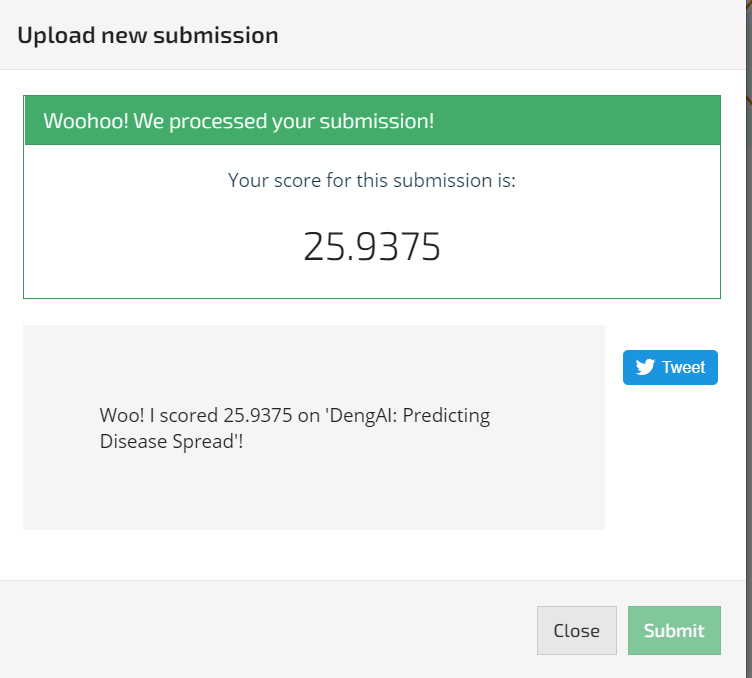